In [3]:
import pandas as pd
import keras
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Dense, LSTM, Flatten, Embedding, Dropout , Activation, GRU, Flatten, Input, Bidirectional, GlobalMaxPool1D, Convolution1D, TimeDistributed, Bidirectional
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers

In [4]:
df = pd.read_csv('ilk_asama_data.csv')
data = df.copy()
print(data.shape)
data.head()

(14882, 2)


,line,y
0,şarkıcı norma zimmer ile iyi bir ikili oluşturdu.,1
1,gemiler kariyerleri boyunca sık sık birlikte h...,1
2,ayrıca; yarı x iletken özellikleri vardır.,0
3,futbol oynadığı dönemlerde orta saha pozisyonu...,1
4,i̇ki fenotip ayrım yapmadan bir arada ürerler.,1


In [5]:
X = data['line']
y = data['y']

In [6]:
vocab_size = 15000
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X)
list_tokenized_train = tokenizer.texts_to_sequences(X)

In [7]:
maxlen = 7
X_train_padded = pad_sequences(list_tokenized_train, maxlen=maxlen)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_train_padded, y, test_size=0.2, stratify=y)

In [9]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, verbose=1)

In [10]:
embed_size = 128
model = Sequential()
model.add(Embedding(vocab_size, embed_size))
model.add(Bidirectional(LSTM(64, return_sequences = True)))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1920000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          41216     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 2,060,097
Trainable params: 2,060,097
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy'])

batch_size = 10000
epochs = 7
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[early_stopping_cb])

Epoch 1/7
2/2 [==============================] - 4s 2s/step - loss: 0.6933 - auc: 0.4820 - accuracy: 0.4793 - val_loss: 0.6904 - val_auc: 0.8038 - val_accuracy: 0.6423
Epoch 2/7
2/2 [==============================] - 0s 146ms/step - loss: 0.6901 - auc: 0.8181 - accuracy: 0.6431 - val_loss: 0.6868 - val_auc: 0.9106 - val_accuracy: 0.6591
Epoch 3/7
2/2 [==============================] - 0s 138ms/step - loss: 0.6862 - auc: 0.9238 - accuracy: 0.6768 - val_loss: 0.6824 - val_auc: 0.9541 - val_accuracy: 0.6893
Epoch 4/7
2/2 [==============================] - 0s 130ms/step - loss: 0.6812 - auc: 0.9702 - accuracy: 0.7250 - val_loss: 0.6766 - val_auc: 0.9680 - val_accuracy: 0.7918
Epoch 5/7
2/2 [==============================] - 0s 135ms/step - loss: 0.6742 - auc: 0.9816 - accuracy: 0.8286 - val_loss: 0.6688 - val_auc: 0.9697 - val_accuracy: 0.8589
Epoch 6/7
2/2 [==============================] - 0s 133ms/step - loss: 0.6645 - auc: 0.9844 - accuracy: 0.9096 - val_loss: 0.6585 - val_auc: 0.9695 

burada çıktı olarak düzeltilmiş metni almak istiyoruz!!!!

In [22]:
#pred = tokenizer.texts_to_sequences(["bir X çok misafir gelir bizim eve "])
pred = tokenizer.texts_to_sequences(["Sahip olduğu tüm malvarlığını bir miras X yedi gibi tüketti"])
#pred = tokenizer.texts_to_sequences(["sana güzel bir X takım alalım"])

print(pred)
maxlen = 7
padded_pred = pad_sequences(pred, maxlen=maxlen)
print(padded_pred)
model.predict(padded_pred)

[[371, 183, 95, 2, 5217, 1, 423, 198]]
[[ 183   95    2 5217    1  423  198]]


array([[0.4655557]], dtype=float32)

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score

y_pred = model.predict_classes(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Data: %.2f%%" % (accuracy * 100.0))

print(confusion_matrix(y_test, y_pred ))
print(classification_report(y_test, y_pred, digits=4))
print(roc_auc_score(y_test, y_pred))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Accuracy on Test Data: 87.97%
[[1425   63]
 [ 295 1194]]
              precision    recall  f1-score   support

           0     0.8285    0.9577    0.8884      1488
           1     0.9499    0.8019    0.8696      1489

    accuracy                         0.8797      2977
   macro avg     0.8892    0.8798    0.8790      2977
weighted avg     0.8892    0.8797    0.8790      2977

0.8797708735024589


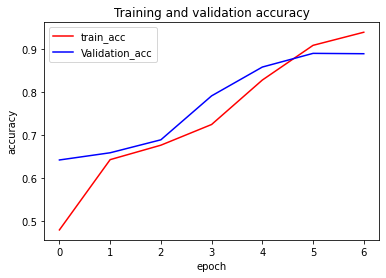

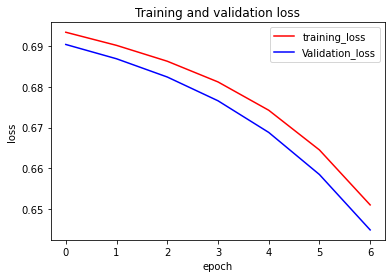

0.9400783777236938
0.8908480405807495


In [14]:
import matplotlib.pyplot as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='train_acc')
plt.plot(epochs, val_acc, 'b', label='Validation_acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='training_loss')
plt.plot(epochs, val_loss, 'b', label='Validation_loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

print(np.max(history.history['accuracy']))
print(np.max(history.history['val_accuracy']))

In [15]:
model.save("Model_birlesik_ayri.h5")
print("Saved model to disk")

Saved model to disk


In [16]:
model.load_weights("Model_birlesik_ayri.h5")

In [17]:
with open('tokenizer_birlesik_ayri.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)